In [20]:
import pandas as pd
data=pd.read_csv('/Downloads/Geolife Trajectories 1.3/geolife.csv')

In [21]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [22]:
data.columns

Index(['lat', 'lon', 'alt', 'time', 'destination', 'mode_of_transport',
       'start_time', 'end_time', 'tid', 'time_diff', 'distance', 'speed',
       'acceleration', 'user'],
      dtype='object')

In [23]:
filtered_data = data[data['mode_of_transport'].isin([10, 3])]

In [24]:
filtered_data[['lat_destination', 'lon_destination']] = pd.DataFrame(filtered_data['destination'].apply(eval).tolist(), index=filtered_data.index)

C:\Users\z044971\AppData\Local\Temp/ipykernel_6576/3314771656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[['lat_destination', 'lon_destination']] = pd.DataFrame(filtered_data['destination'].apply(eval).tolist(), index=filtered_data.index)
C:\Users\z044971\AppData\Local\Temp/ipykernel_6576/3314771656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[['lat_destination', 'lon_destination']] = pd.DataFrame(filtered_data['destination'].apply(eval).tolist(), index=filtered_da

In [25]:
# Convert the time column to datetime
filtered_data['time'] = pd.to_datetime(filtered_data['time'])

# Extract hour, day, weekday, and week number
filtered_data['hour'] = filtered_data['time'].dt.hour
filtered_data['day'] = filtered_data['time'].dt.day  # Day of the month
filtered_data['week'] = filtered_data['time'].dt.isocalendar().week  # ISO week number


C:\Users\z044971\AppData\Local\Temp/ipykernel_6576/2729726634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])
C:\Users\z044971\AppData\Local\Temp/ipykernel_6576/2729726634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour'] = filtered_data['time'].dt.hour
C:\Users\z044971\AppData\Local\Temp/ipykernel_6576/2729726634.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [26]:
# Group by 'user' and 'tid', then take the first 'lat' and 'lon' for each trip as the departure coordinates
df_departure = filtered_data.groupby(['user', 'tid']).first().reset_index()

# Merge the departure coordinates back into the original dataframe
filtered_data = filtered_data.merge(df_departure[['user', 'tid', 'lat', 'lon']], on=['user', 'tid'], suffixes=('', '_departure'))

# Rename the columns for clarity
filtered_data.rename(columns={'lat_departure': 'departure_lat', 'lon_departure': 'departure_lon'}, inplace=True)

In [27]:
##partial data

In [32]:
def first_prediction(gps_data):
    partial_data_list = []
    
    if len(gps_data) < 10:
        # If there are less than 10 points, return partial data list filled with 0s
        partial_data_list = [0] * len(gps_data)
    else:
        # For the first 10 points, partial data is set to 0
        partial_data_list = [0] * 10
    
    return partial_data_list

# Function to get 5 first points + 5 points up to the current position
def current_position_prediction(gps_data, current_index):
    # First 5 points from the start
    first_5_points = gps_data.iloc[:5]
    
    # Last 5 points from the current position
    current_5_points = gps_data.iloc[current_index-5:current_index]
    
    # Combine both sets into a flat list
    partial_list = first_5_points[['lat', 'lon']].values.flatten().tolist() + \
                   current_5_points[['lat', 'lon']].values.flatten().tolist()
    
    return partial_list

# Main function to generate partial data column for the whole trip
def generate_partial_data(gps_data):
    # First 10 points get partial data set to 0
    partial_data_list = first_prediction(gps_data)
    
    # Loop through data starting from position 10 to calculate partial data
    for current_index in range(10, len(gps_data)):
        partial_list = current_position_prediction(gps_data, current_index)
        partial_data_list.append(partial_list)
    
    return partial_data_list

# Main function to process all trips and update the original filtered_data with the 'partial' column
def process_trips(filtered_data):
    # Group data by trip id 'tid'
    grouped = filtered_data.groupby('tid')

    # Initialize an empty list to store partial data for all trips
    partial_data_all_trips = []

    # Iterate over each trip group
    for tid, trip_data in grouped:
        #print(f"Processing trip {tid}...")

        # Extract the lat, lon columns for this trip
        gps_data = trip_data[['lat', 'lon']]

        # Generate partial data for this trip
        partial_data_list = generate_partial_data(gps_data)

        # Append the partial data list to the partial_data_all_trips list
        partial_data_all_trips.extend(partial_data_list)

    # Assign the complete list of partial data as a new column in the filtered_data DataFrame
    filtered_data['partial'] = partial_data_all_trips

    return filtered_data
process_trips(filtered_data)

,lat,lon,alt,time,destination,mode_of_transport,start_time,end_time,tid,time_diff,...,user,lat_destination,lon_destination,hour,day,week,departure_lat,departure_lon,cluster,partial
0,39.995196,116.327816,181.0512,2008-09-27 11:42:13,"(39.135816, 117.216816)",3,2008-09-27 11:42:13,2008-09-27 12:29:29,Data\010_207,-6136872.0,...,10,39.135816,117.216816,11,27,39,39.995196,116.327816,0,0
1,39.995223,116.327865,181.0512,2008-09-27 11:42:14,"(39.135816, 117.216816)",3,2008-09-27 11:42:13,2008-09-27 12:29:29,Data\010_207,1.0,...,10,39.135816,117.216816,11,27,39,39.995196,116.327816,0,0
2,39.995258,116.327906,181.9656,2008-09-27 11:42:15,"(39.135816, 117.216816)",3,2008-09-27 11:42:13,2008-09-27 12:29:29,Data\010_207,1.0,...,10,39.135816,117.216816,11,27,39,39.995196,116.327816,0,0
3,39.995293,116.327940,181.9656,2008-09-27 11:42:16,"(39.135816, 117.216816)",3,2008-09-27 11:42:13,2008-09-27 12:29:29,Data\010_207,1.0,...,10,39.135816,117.216816,11,27,39,39.995196,116.327816,0,0
4,39.995334,116.327954,181.9656,2008-09-27 11:42:17,"(39.135816, 117.216816)",3,2008-09-27 11:42:13,2008-09-27 12:29:29,Data\010_207,1.0,...,10,39.135816,117.216816,11,27,39,39.995196,116.327816,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715049,39.992520,116.326051,55.7784,2008-11-07 10:21:56,"(40.08931, 116.298673)",10,2008-11-07 09:11:06,2008-11-07 10:22:06,Data\179_478,2.0,...,179,40.089310,116.298673,10,7,45,39.996471,116.308879,0,"[39.996471, 116.308879, 39.996368, 116.308919,..."
715050,39.992491,116.325979,55.1688,2008-11-07 10:21:58,"(40.08931, 116.298673)",10,2008-11-07 09:11:06,2008-11-07 10:22:06,Data\179_478,2.0,...,179,40.089310,116.298673,10,7,45,39.996471,116.308879,0,"[39.996471, 116.308879, 39.996368, 116.308919,..."
715051,39.992405,116.325812,55.1688,2008-11-07 10:22:00,"(40.08931, 116.298673)",10,2008-11-07 09:11:06,2008-11-07 10:22:06,Data\179_478,2.0,...,179,40.089310,116.298673,10,7,45,39.996471,116.308879,0,"[39.996471, 116.308879, 39.996368, 116.308919,..."
715052,39.992402,116.325784,55.1688,2008-11-07 10:22:02,"(40.08931, 116.298673)",10,2008-11-07 09:11:06,2008-11-07 10:22:06,Data\179_478,2.0,...,179,40.089310,116.298673,10,7,45,39.996471,116.308879,0,"[39.996471, 116.308879, 39.996368, 116.308919,..."


In [19]:
##historical data grouped by departure zone

In [33]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Deduplicate the DataFrame to unique coordinates
unique_coords = filtered_data[['departure_lat', 'departure_lon']].drop_duplicates()

# Apply DBSCAN to unique coordinates
dbscan = DBSCAN(eps=0.5, min_samples=5)
unique_coords['cluster'] = dbscan.fit_predict(scaler.fit_transform(unique_coords))

# Now, you can map back the cluster labels to the original DataFrame if needed
filtered_data = filtered_data.merge(unique_coords[['departure_lat', 'departure_lon', 'cluster']], 
                          on=['departure_lat', 'departure_lon'], 
                          how='left', 
                          suffixes=('', '_unique'))

In [34]:
filtered_data['cluster'].value_counts()

 0    666443
 3     17486
 4     17103
-1      5562
 1      5490
 2      2020
 5       950
Name: cluster, dtype: int64

In [35]:
from sklearn.metrics import silhouette_score

# Ensure that noise points (label -1) are excluded for Silhouette calculation
non_noise_coords = unique_coords[unique_coords['cluster'] != -1]

# Silhouette score calculation (excluding noise)
if non_noise_coords['cluster'].nunique() > 1:  # Only calculate if there's more than one cluster
    score = silhouette_score(scaler.fit_transform(non_noise_coords[['departure_lat', 'departure_lon']]), non_noise_coords['cluster'])
    print(f'Silhouette Score: {score}')
else:
    print('Silhouette Score cannot be calculated because there is only one cluster.')



Silhouette Score: 0.652354671814542


In [55]:
def extract_factors(trip_data):
    departure_area = trip_data['cluster'].iloc[0]
    hour = trip_data['hour'].iloc[0]
    week = trip_data['week'].iloc[0]
    day = trip_data['day'].iloc[0]
    return departure_area, hour, week, day

# Function to query historical trajectories based on conditions
def query_historical_data(trajectory, historical_data, K=10):
    H = []  # Initialize historical information
    
    # Extract factors for the input trajectory
    t_departure_area, t_hour, t_week, t_day = extract_factors(trajectory)
    
    # Iterate over each historical trip in historical_data
    for idx, hist_trip in historical_data.groupby('tid'):
        # Extract factors for the historical trajectory
        h_departure_area, h_hour, h_week, h_day = extract_factors(hist_trip)
        
        # Check if the historical trip matches based on departure area, hour, day, and week
        if (t_departure_area == h_departure_area and
            abs(t_hour-h_hour)<=4 and
            t_week == h_week and
            abs(t_day - h_day)<=1):
            
            # Append the destination lat, lon from the historical trip
            destination = hist_trip.iloc[-1][['lat_destination', 'lon_destination']].values.tolist()
            H.append(destination)
        
        # Stop if we've collected K destinations
        if len(H) >= K:
            break
    
    # Ensure H has exactly K items, filled with [None, None] if necessary
    while len(H) < K:
        H.append([None, None])
    
    return H

# Main function to generate historical data for all trajectories
def generate_historical_data(filtered_data):
    grouped = filtered_data.groupby('cluster')
    filtered_data_copy = filtered_data.copy()
    historical_data_column = []
    
    for zone, trip_data in grouped:
        #print(f"Processing departure zone {zone}...")
        
        # Query historical data for the current trajectory
        H = query_historical_data(trip_data, filtered_data, K=10)
        for idx, hist in enumerate(H):
            print(f"  Historic data {idx + 1}: {hist}")
#         # Print the historical data collected for each trajectory
#         for idx, hist in enumerate(H):
#             print(f"  Historic data {idx + 1}: {hist}")
        
        # Add the historical data to every row in the current trip
        historical_data_column.extend([H] * len(trip_data))
    
    filtered_data_copy['historical_data_departure'] = historical_data_column
    return filtered_data_copy

filtered_data_with_history = generate_historical_data(filtered_data)


  Historic data 1: [43.847158, 125.289116]
  Historic data 2: [18.292739, 109.200128]
  Historic data 3: [18.292739, 109.200128]
  Historic data 4: [18.292739, 109.200128]
  Historic data 5: [18.292739, 109.200128]
  Historic data 6: [None, None]
  Historic data 7: [None, None]
  Historic data 8: [None, None]
  Historic data 9: [None, None]
  Historic data 10: [None, None]
  Historic data 1: [39.135816, 117.216816]
  Historic data 2: [39.137299, 117.220753]
  Historic data 3: [39.991323, 116.317309]
  Historic data 4: [39.136366, 117.218021]
  Historic data 5: [39.136366, 117.218021]
  Historic data 6: [39.114293, 117.187586]
  Historic data 7: [39.114293, 117.187586]
  Historic data 8: [39.136106, 117.218443]
  Historic data 9: [39.137413, 117.219833]
  Historic data 10: [39.137413, 117.219833]
  Historic data 1: [39.473507, 76.000835]
  Historic data 2: [39.473507, 76.000835]
  Historic data 3: [39.473507, 76.000835]
  Historic data 4: [39.473507, 76.000835]
  Historic data 5: [39.49

In [56]:
filtered_data_with_history['historical_data_departure']

0         [[43.847158, 125.289116], [18.292739, 109.2001...
1         [[43.847158, 125.289116], [18.292739, 109.2001...
2         [[43.847158, 125.289116], [18.292739, 109.2001...
3         [[43.847158, 125.289116], [18.292739, 109.2001...
4         [[43.847158, 125.289116], [18.292739, 109.2001...
                                ...                        
715049    [[22.6085766, 114.0181299], [22.6085766, 114.0...
715050    [[22.6085766, 114.0181299], [22.6085766, 114.0...
715051    [[22.6085766, 114.0181299], [22.6085766, 114.0...
715052    [[22.6085766, 114.0181299], [22.6085766, 114.0...
715053    [[22.6085766, 114.0181299], [22.6085766, 114.0...
Name: historical_data_departure, Length: 715054, dtype: object

In [58]:
df = filtered_data_with_history[filtered_data_with_history['partial'] != 0]

In [59]:
from sklearn.preprocessing import MinMaxScaler
time_feature=['hour','day','week']
categorical=df[time_feature]
sc = MinMaxScaler(feature_range=(-1,1))

categorical_scaled = sc.fit_transform(categorical)

In [60]:
partial=np.array(df['partial'].tolist())
partial_scaled = scaler.fit_transform(partial)

In [61]:
print(df['historical_data_departure'].iloc[-1])

[[22.6085766, 114.0181299], [22.6085766, 114.0181299], [22.6085766, 114.0181299], [22.6085766, 114.0181299], [22.5720266, 113.8821333], [22.5589066, 113.9029166], [22.5589066, 113.9029166], [22.5589066, 113.9029166], [23.1483466, 113.3166616], [23.1483466, 113.3166616]]


In [62]:
historical = df['historical_data_departure'].values

# Flatten each row into a single array
historical_flattened = [np.array(item).flatten() for item in historical]
historical_scaled = scaler.fit_transform(historical_flattened)

In [63]:
historical_scaled

array([[ 1.89806814,  0.38359585, -7.25896715, ...,         nan,
                nan,         nan],
       [ 1.89806814,  0.38359585, -7.25896715, ...,         nan,
                nan,         nan],
       [ 1.89806814,  0.38359585, -7.25896715, ...,         nan,
                nan,         nan],
       ...,
       [-7.56921642,  0.08263866, -5.77385253, ...,  0.0611493 ,
        -7.6185964 ,  0.06304234],
       [-7.56921642,  0.08263866, -5.77385253, ...,  0.0611493 ,
        -7.6185964 ,  0.06304234],
       [-7.56921642,  0.08263866, -5.77385253, ...,  0.0611493 ,
        -7.6185964 ,  0.06304234]])

In [64]:
import numpy as np

historical_data_filled = np.nan_to_num(historical_scaled, nan=0)


In [65]:
historical_data_filled

array([[ 1.89806814,  0.38359585, -7.25896715, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.89806814,  0.38359585, -7.25896715, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.89806814,  0.38359585, -7.25896715, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-7.56921642,  0.08263866, -5.77385253, ...,  0.0611493 ,
        -7.6185964 ,  0.06304234],
       [-7.56921642,  0.08263866, -5.77385253, ...,  0.0611493 ,
        -7.6185964 ,  0.06304234],
       [-7.56921642,  0.08263866, -5.77385253, ...,  0.0611493 ,
        -7.6185964 ,  0.06304234]])

In [66]:
print(categorical_scaled.shape)
print(partial_scaled.shape)
print(historical_data_filled.shape)

(689634, 3)
(689634, 20)
(689634, 20)


In [67]:
scaled_target = scaler.fit_transform(df[['lat_destination', 'lon_destination']])

In [68]:
categorical_train, categorical_test, partial_train, partial_test, historic_train, historic_test, y_train, y_test = train_test_split(
    categorical_scaled,
    partial_scaled,
    historical_data_filled,
    scaled_target,  
    test_size=0.2,  
    random_state=42  
)

In [69]:
print(categorical_train.shape)
print(partial_train.shape)
print(historic_train.shape)
print(y_train.shape)

(551707, 3)
(551707, 20)
(551707, 20)
(551707, 2)


In [70]:
print(categorical_test.shape)
print(partial_test.shape)
print(historic_test.shape)
print(y_test.shape)

(137927, 3)
(137927, 20)
(137927, 20)
(137927, 2)


In [71]:
categorical_reshape = categorical_train.reshape((551707, 1, 3)) 
partial_reshape = partial_train.reshape((551707, 1, 20)) 
historical_reshape = historic_train.reshape((551707, 1, 20))
y_reshape=y_train.reshape((551707, 1, 2))

In [72]:
categorical_test_reshape = categorical_test.reshape((137927, 1, 3)) 
partial_test_reshape = partial_test.reshape((137927, 1, 20)) 
historical_test_reshape = historic_test.reshape((137927, 1, 20))
y_test_reshape=y_test.reshape((137927, 1, 2))

In [73]:

def haversine_distance(y_true, y_pred):
    # Earth's radius in kilometers
    R = 6371.0
    
    # Reshape if necessary to ensure [batch_size, 2]
    y_true = tf.reshape(y_true, (-1, 2))
    y_pred = tf.reshape(y_pred, (-1, 2))
    
    # Convert degrees to radians manually
    pi_div_180 = tf.constant(np.pi / 180.0, dtype=tf.float32)
    
    y_true_rad = tf.multiply(y_true, pi_div_180)
    y_pred_rad = tf.multiply(y_pred, pi_div_180)
    
    lat_true, lon_true = tf.split(y_true_rad, num_or_size_splits=2, axis=1)
    lat_pred, lon_pred = tf.split(y_pred_rad, num_or_size_splits=2, axis=1)
    
    # Calculate the differences between true and predicted coordinates
    delta_lat = lat_pred - lat_true
    delta_lon = lon_pred - lon_true
    
    # Apply the Haversine formula
    a = tf.sin(delta_lat / 2.0) ** 2 + tf.cos(lat_true) * tf.cos(lat_pred) * tf.sin(delta_lon / 2.0) ** 2
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    # Calculate distance in kilometers
    distance = R * c
    
    # Return mean distance over the batch
    return tf.reduce_mean(distance)

In [155]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Masking, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the Optuna objective function
def objective(trial):

    # Suggest hyperparameters for LSTM layers
    lstm_units_partial = trial.suggest_int('lstm_units_partial', 64, 256)
    lstm_units_historic = trial.suggest_int('lstm_units_historic', 32, 128)
    lstm_units_categorical = trial.suggest_int('lstm_units_categorical', 32, 128)
    
    # Suggest hyperparameters for dense layers
    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 4)  # Decide number of dense layers
    num_dropout_layers = trial.suggest_int('num_dropout_layers', 0, num_dense_layers)  # Decide number of dropout layers
    dense_units = [trial.suggest_int(f'dense_units_{i}', 32, 512) for i in range(num_dense_layers)]
    
    # Suggest dropout rate, recurrent dropout, learning rate, and L2 regularization
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    recurrent_dropout_rate = trial.suggest_float('recurrent_dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)

    # Define input shapes
    input_partial = Input(shape=(None, 20), name="partial_input")
    input_historic = Input(shape=(None, 20), name="historic_input")
    input_categorical = Input(shape=(None, 3), name="categorical_input")

    # Masking for variable-length sequences
    masked_partial = Masking()(input_partial)
    masked_historic = Masking()(input_historic)
    masked_categorical = Masking()(input_categorical)

    # LSTM layers with Dropout and L2 regularization
    lstm_partial = LSTM(lstm_units_partial, return_sequences=False, 
                        dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate, 
                        kernel_regularizer=regularizers.l2(l2_reg))(masked_partial)
    
    lstm_historic = LSTM(lstm_units_historic, return_sequences=False, 
                         dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate, 
                         kernel_regularizer=regularizers.l2(l2_reg))(masked_historic)
    
    lstm_categorical = LSTM(lstm_units_categorical, return_sequences=False, 
                            dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate, 
                            kernel_regularizer=regularizers.l2(l2_reg))(masked_categorical)

    # Concatenate the outputs of the three branches
    concatenated = Concatenate()([lstm_partial, lstm_historic, lstm_categorical])

    # Dynamically add Dense and Dropout layers
    x = concatenated
    for i in range(num_dense_layers):
        x = Dense(dense_units[i], activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = BatchNormalization()(x)
        if i < num_dropout_layers:  # Apply dropout layers only where applicable
            x = Dropout(dropout_rate)(x)

    # Output layer for lat_destination and lon_destination
    output = Dense(2, activation='linear')(x)

    # Create the model
    model = Model(inputs=[input_partial, input_historic, input_categorical], outputs=output)

    # Compile the model with Adam optimizer and haversine_distance loss
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=haversine_distance)

    # Early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

    # Train the model
    history = model.fit([partial_reshape, historical_reshape, categorical_reshape], y_reshape,
                        validation_data=([partial_test_reshape, historical_test_reshape, categorical_test_reshape], y_test_reshape),
                        epochs=50,
                        batch_size=32,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0)

    # Get the validation loss at the last epoch
    val_loss = history.history['val_loss'][-1]
    
    return val_loss

# Create the Optuna study and optimize it
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

# Best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2024-10-16 19:21:13,772] A new study created in memory with name: no-name-d9dc353c-b71c-41cd-a93f-87ce12ed5fdd
C:\Users\z044971\AppData\Local\Temp/ipykernel_14468/1162140685.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\z044971\AppData\Local\Temp/ipykernel_14468/1162140685.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)
[I 2024-10-16 19:44:34,996] Trial 0 finished with value: 44.695709228515625 and parameters: {'lstm_units_partial': 183, 'lstm_units_historic': 103, 'lstm_units_categorical': 43, 'num_dense_layers': 1, 'num_

Best hyperparameters:  {'lstm_units_partial': 201, 'lstm_units_historic': 86, 'lstm_units_categorical': 82, 'num_dense_layers': 2, 'num_dropout_layers': 1, 'dense_units_0': 504, 'dense_units_1': 33, 'dropout_rate': 0.10229704053690594, 'recurrent_dropout_rate': 0.1982443380785452, 'learning_rate': 1.0190797945910089e-05, 'l2_reg': 0.0019196761230913198}


In [161]:
study.best_value

31.546024322509766

In [75]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Hyperparameters
lstm_units_partial = 201
lstm_units_historic = 86
lstm_units_categorical = 82
num_dense_layers = 2
dense_units_0 = 504
dense_units_1 = 33
dropout_rate = 0.10229704053690594
recurrent_dropout_rate = 0.1982443380785452
learning_rate = 1.0190797945910089e-05
l2_reg = 0.0019196761230913198

# Inputs
partial_input = Input(shape=(None, 20), name="partial_input")
historical_input = Input(shape=(None, 20), name="historical_input")
categorical_input = Input(shape=(None, 3), name="categorical_input")

# LSTM layers
partial_lstm = LSTM(lstm_units_partial, 
                    recurrent_dropout=recurrent_dropout_rate, 
                    kernel_regularizer=l2(l2_reg))(partial_input)

historical_lstm = LSTM(lstm_units_historic, 
                       recurrent_dropout=recurrent_dropout_rate, 
                       kernel_regularizer=l2(l2_reg))(historical_input)

categorical_lstm = LSTM(lstm_units_categorical, 
                        recurrent_dropout=recurrent_dropout_rate, 
                        kernel_regularizer=l2(l2_reg))(categorical_input)

# Concatenate LSTM outputs
concatenated = tf.keras.layers.concatenate([partial_lstm, historical_lstm, categorical_lstm])

# Dense layers
x = Dense(dense_units_0, activation='relu', kernel_regularizer=l2(l2_reg))(concatenated)

if num_dense_layers > 1:
    x = Dense(dense_units_1, activation='relu', kernel_regularizer=l2(l2_reg))(x)

# Dropout layer (if specified)
if dropout_rate > 0:
    x = Dropout(dropout_rate)(x)

# Output layer (adjust as needed for your task, e.g., regression or classification)
output = Dense(2, activation='linear')(x)  # 2 outputs for latitude and longitude

# Compile the model
model = Model(inputs=[partial_input, historical_input, categorical_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=haversine_distance)

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ partial_input (InputLayer)    │ (None, None, 20)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ historical_input (InputLayer) │ (None, None, 20)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ categorical_input             │ (None, None, 3)           │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ (None, 201)               │         178,488 │ partial_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_4 (LSTM)                 │ (None, 86)                │          36,808 │ historical_input[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_5 (LSTM)                 │ (None, 82)                │          28,208 │ categorical_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 369)               │               0 │ lstm_3[0][0],              │
│                               │                           │                 │ lstm_4[0][0], lstm_5[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 504)               │         186,480 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 33)                │          16,665 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 33)                │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 2)                 │              68 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 446,717 (1.70 MB)

 Trainable params: 446,717 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
# Callbacks: EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    x=[partial_reshape, historical_reshape, categorical_reshape],
    y=y_reshape,
    validation_data=([partial_test_reshape, historical_test_reshape, categorical_test_reshape], y_test_reshape),
    epochs=10,  # Adjust based on your needs
    batch_size=32,  # Adjust based on your dataset and hardware
    callbacks=[early_stopping, reduce_lr],  # Apply both callbacks
    verbose=1
)


Epoch 1/10
17241/17241 ━━━━━━━━━━━━━━━━━━━━ 100s 6ms/step - loss: 18.6542 - val_loss: 17.5848 - learning_rate: 1.0191e-05
Epoch 2/10
17241/17241 ━━━━━━━━━━━━━━━━━━━━ 100s 6ms/step - loss: 18.4270 - val_loss: 17.1486 - learning_rate: 1.0191e-05
Epoch 3/10
17241/17241 ━━━━━━━━━━━━━━━━━━━━ 100s 6ms/step - loss: 18.1802 - val_loss: 16.9819 - learning_rate: 1.0191e-05
Epoch 4/10
17241/17241 ━━━━━━━━━━━━━━━━━━━━ 106s 6ms/step - loss: 17.9637 - val_loss: 16.3903 - learning_rate: 1.0191e-05
Epoch 5/10
17241/17241 ━━━━━━━━━━━━━━━━━━━━ 101s 6ms/step - loss: 17.6768 - val_loss: 16.6097 - learning_rate: 1.0191e-05
Epoch 6/10
17241/17241 ━━━━━━━━━━━━━━━━━━━━ 108s 6ms/step - loss: 17.6162 - val_loss: 16.1027 - learning_rate: 1.0191e-05
Epoch 7/10
17241/17241 ━━━━━━━━━━━━━━━━━━━━ 101s 6ms/step - loss: 17.4912 - val_loss: 15.4496 - learning_rate: 1.0191e-05
Epoch 8/10
17241/17241 ━━━━━━━━━━━━━━━━━━━━ 99s 6ms/step - loss: 17.3147 - val_loss: 16.0936 - learning_rate: 1.0191e-05
Epoch 9/10
17241/17241 ━━

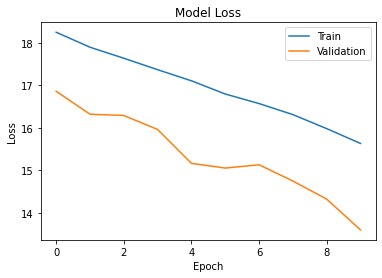

In [210]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [211]:
loss = model.evaluate([partial_test_reshape,historical_test_reshape, categorical_test_reshape], y_test_reshape)
print(f"Test Loss (Haversine Distance): {loss}")


4311/4311 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 13.7210
Test Loss (Haversine Distance): 13.600610733032227


In [213]:
predictions = model.predict([partial_test_reshape, historical_test_reshape,categorical_test_reshape])
print(predictions)


4311/4311 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
[[ 2.2566206  -6.1507974 ]
 [ 0.01061103  0.16307856]
 [ 0.02365507  0.16096142]
 ...
 [ 0.0370772   0.14860938]
 [ 0.01298288  0.16248001]
 [ 0.0116689   0.16315109]]


In [214]:
y_predicted=scaler.inverse_transform(predictions)

In [215]:
y_predicted

array([[  47.51476 , -116.82875 ],
       [  39.931335,  116.40997 ],
       [  39.975376,  116.331764],
       ...,
       [  40.020695,  115.87547 ],
       [  39.939342,  116.38786 ],
       [  39.934906,  116.41265 ]], dtype=float32)

In [216]:
y_actual=scaler.inverse_transform(y_test)
print(y_actual)

[[  47.6122233  -122.1976416 ]
 [  39.95437     116.35537833]
 [  39.9755      116.3305283 ]
 ...
 [  40.0759083   116.3233049 ]
 [  40.01193     116.5614783 ]
 [  39.9267083   116.4712833 ]]


In [217]:
import numpy as np

def haversine(coord1, coord2):
    # Radius of the Earth in kilometers
    R = 6371.0  
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    
    # Compute differences between coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distance in kilometers
    distance = R * c
    return distance

prediction=[  39.975376,  116.331764]
true=[  39.9755     , 116.3305283 ]

# Calculate Haversine distance
distance = haversine(prediction, true)
print(f"The Haversine distance is: {distance:.2f} km")


The Haversine distance is: 0.11 km


In [218]:
import folium


# Create a map centered around the midpoint of the two points
midpoint = [(prediction[0] + true[0]) / 2, (prediction[1] + true[1]) / 2]
mymap = folium.Map(location=midpoint, zoom_start=6)

# Add markers for the two points
folium.Marker(location=prediction, popup="prediction", icon=folium.Icon(color='blue')).add_to(mymap)
folium.Marker(location=true, popup="true", icon=folium.Icon(color='red')).add_to(mymap)

# Draw a line between the two points
folium.PolyLine(locations=[prediction, true], color='green', weight=5, opacity=0.8).add_to(mymap)

# Display the map
mymap